# Summary statistics

`ScmRun` objects have methods specific to calculating summary statistics. In this notebook we demonstrate them.

At present, the following methods are available:

- `process_over`
- `quantiles_over`
- `groupby`
- `groupby_all_except`

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scmdata.run import ScmRun, run_append

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Helper bits and piecs

In [3]:
def new_timeseries(
    n=101,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<ScmRun (timeseries: 30, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  Atmospheri

## `process_over`

The `process_over` method allows us to calculate a specific set of statistics on groups of timeseries. A number of pandas functions can be called including "sum", "mean" and "describe".

In [5]:
print(runs.process_over.__doc__)


        Process the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        operation : str or func
            The operation to perform.

            If a string is provided, the equivalent pandas groupby function is used. Note
            that not all groupby functions are available as some do not make sense for
            this particular application. Additional information about the arguments for
            the pandas groupby functions can be found at <https://pandas.pydata.org/pan
            das-docs/stable/reference/groupby.html>`_.

            If a function is provided, it will be applied to each group. The function must
            take a dataframe as its first argument and return a DataFrame, Series or scalar.

            Note that quantile means the value of the data at a given point in the cumulative
        

### Mean

In [6]:
# NBVAL_IGNORE_OUTPUT
mean = runs.process_over(cols="run_id", operation="mean")
mean

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.507440    1.009117    1.352261    2.140397    2.114652    3.007618  ...   53.877790   45.203341   44.174207   47.311248   40.127144   35.624771   42.326395
                        W/m^2 Radiative Forcing                      0.0    0.613253    1.022358    1.425384    2.370510    1.675960    2.645303  ...   42.114376   43.934690   39.238384   44.880488   38.439152   61.006717   50.724298
                        ppm   Atmospheric Concentrations|CO2         0.0    0.372314    0.818866    1.492401    2.243306    2.292707    2.718678  ...   46.278662   60.848846   61.162341   54.373889   67.448361   53.789182   63.126450

[3 rows x 101 columns]

### Median

In [7]:
# NBVAL_IGNORE_OUTPUT
median = runs.process_over(cols="run_id", operation="median")
median

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.499522    1.056520    1.283922    2.474044    2.149388    3.198761  ...   57.288920   45.163347   54.826824   49.744409   37.348709   30.548644   37.804128
                        W/m^2 Radiative Forcing                      0.0    0.662010    1.158476    1.374953    2.577551    1.369386    2.578138  ...   40.729492   44.457833   24.120197   57.175035   41.089799   64.751718   44.963239
                        ppm   Atmospheric Concentrations|CO2         0.0    0.341001    0.709436    1.533881    2.465021    1.620769    2.803643  ...   47.717428   67.312645   61.883613   59.211711   74.260682   58.693106   67.046300

[3 rows x 101 columns]

### Arbitrary functions

You are also able to run arbitrary functions for each group

In [8]:
# NBVAL_IGNORE_OUTPUT
def mean_and_invert(df, axis=0):
    # Take a mean across the group and then invert the result
    return -df.mean(axis=axis)


runs.process_over("run_id", operation=mean_and_invert)

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                   -0.0   -0.507440   -1.009117   -1.352261   -2.140397   -2.114652   -3.007618  ...  -53.877790  -45.203341  -44.174207  -47.311248  -40.127144  -35.624771  -42.326395
                        W/m^2 Radiative Forcing                     -0.0   -0.613253   -1.022358   -1.425384   -2.370510   -1.675960   -2.645303  ...  -42.114376  -43.934690  -39.238384  -44.880488  -38.439152  -61.006717  -50.724298
                        ppm   Atmospheric Concentrations|CO2        -0.0   -0.372314   -0.818866   -1.492401   -2.243306   -2.292707   -2.718678  ...  -46.278662  -60.848846  -61.162341  -54.373889  -67.448361  -53.789182  -63.126450

[3 rows x 101 columns]

In [9]:
# NBVAL_IGNORE_OUTPUT
runs.process_over("run_id", operation=mean_and_invert, axis=1)

model    region  run_id  scenario  unit   variable                      
example  World   0       ssp119    K      Surface Temperature              -26.784340
                 1       ssp119    K      Surface Temperature              -25.061592
                 2       ssp119    K      Surface Temperature              -24.324967
                 3       ssp119    K      Surface Temperature              -25.760851
                 4       ssp119    K      Surface Temperature              -23.641711
                 5       ssp119    K      Surface Temperature              -24.712179
                 6       ssp119    K      Surface Temperature              -21.167591
                 7       ssp119    K      Surface Temperature              -25.896897
                 8       ssp119    K      Surface Temperature              -21.562763
                 9       ssp119    K      Surface Temperature              -23.666722
                 0       ssp119    W/m^2  Radiative Forcing        

### Other quantiles

In [10]:
# NBVAL_IGNORE_OUTPUT
lower_likely_quantile = runs.process_over(
    cols="run_id", operation="quantile", q=0.17
)
lower_likely_quantile

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.260405    0.244813    0.539206    0.365752    0.832368    0.603936  ...   31.347542    9.655393   16.039537   10.223782   13.887183   10.081741   22.292815
                        W/m^2 Radiative Forcing                      0.0    0.310070    0.288482    0.709730    1.313012    0.790541    0.980414  ...    9.306027   25.289817   12.302340    3.768290   24.226446   39.431933   26.077998
                        ppm   Atmospheric Concentrations|CO2         0.0    0.148308    0.269284    0.796815    1.299735    1.052407    1.011350  ...   11.511065   28.278777   37.796369   30.714195   44.885098   17.113016   45.232887

[3 rows x 101 columns]

## `quantiles_over`

If you want to calculate more than one summary statistic, `quantiles_over` will calculate and label multiple summary statistics before returning them.

In [11]:
print(runs.quantiles_over.__doc__)


        Calculate quantiles of the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        quantiles
            The quantiles to calculate. This should be a list of quantiles to calculate
            (quantile values between 0 and 1). ``quantiles`` can also include the strings
            "median" or "mean" if these values are to be calculated.

        **kwargs
            Passed to :meth:`~ScmRun.process_over`.

        Returns
        -------
        :class:`pandas.DataFrame`
            The quantiles of the timeseries, grouped by all columns in :attr:`meta`
            other than :obj:`cols`. Each calculated quantile is given a label which is
            stored in the ``quantile`` column within the output index.

        Raises
        ------
        TypeError
            ``operation`` is included in ``kwargs``. The op

In [12]:
# NBVAL_IGNORE_OUTPUT
summary_stats = runs.quantiles_over(
    cols="run_id", quantiles=[0.05, 0.17, 0.5, 0.83, 0.95, "mean", "median"]
)
summary_stats

time                                                                   2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                       quantile                                                                                      ...                                                                                    
example World  ssp119   K     Surface Temperature            0.05             0.0    0.091952    0.038581    0.310445    0.162411    0.765898    0.362882  ...   13.438941    4.307529    7.426212    2.350181   11.791271    4.868138   11.476957
                        W/m^2 Radiative Forcing              0.05             0.0    0.155635    0.119751    0.428247    0.800332    0.587754    0.394187  ...    4.787747   13.892539    5.796146    0.780269   12.249523   24.390382   21.171510
                        ppm   Atmospheric Concentrations|CO2 0.05             0.0    0.098260    0.183183    0.656649    0.496958    0.788053    0.490720  ...    2.823574   15.768127   18.131685    7.143114   31.005105   10.937158   38.662778
                        K     Surface Temperature            0.17             0.0    0.260405    0.244813    0.539206    0.365752    0.832368    0.603936  ...   31.347542    9.655393   16.039537   10.223782   13.887183   10.081741   22.292815
                        W/m^2 Radiative Forcing              0.17             0.0    0.310070    0.288482    0.709730    1.313012    0.790541    0.980414  ...    9.306027   25.289817   12.302340    3.768290   24.226446   39.431933   26.077998
                        ppm   Atmospheric Concentrations|CO2 0.17             0.0    0.148308    0.269284    0.796815    1.299735    1.052407    1.011350  ...   11.511065   28.278777   37.796369   30.714195   44.885098   17.113016   45.232887
                        K     Surface Temperature            0.5              0.0    0.499522    1.056520    1.283922    2.474044    2.149388    3.198761  ...   57.288920   45.163347   54.826824   49.744409   37.348709   30.548644   37.804128
                        W/m^2 Radiative Forcing              0.5              0.0    0.662010    1.158476    1.374953    2.577551    1.369386    2.578138  ...   40.729492   44.457833   24.120197   57.175035   41.089799   64.751718   44.963239
                        ppm   Atmospheric Concentrations|CO2 0.5              0.0    0.341001    0.709436    1.533881    2.465021    1.620769    2.803643  ...   47.717428   67.312645   61.883613   59.211711   74.260682   58.693106   67.046300
                        K     Surface Temperature            0.83             0.0    0.806300    1.753158    2.182916    3.500152    3.029377    5.407099  ...   72.462568   85.564027   66.826688   77.628942   66.597950   63.304362   69.462062
                        W/m^2 Radiative Forcing              0.83             0.0    0.821624    1.607438    2.215968    3.431052    2.720122    4.060242  ...   78.655419   58.517387   73.192908   75.160567   52.629002   86.182923   76.329907
                        ppm   Atmospheric Concentrations|CO2 0.83             0.0    0.613343    1.255077    2.025784    3.072043    4.262796    4.257117  ...   82.511036   83.208960   91.420940   80.231233   88.563911   92.510206   77.231036
                        K     Surface Temperature            0.95             0.0    0.867345    1.897757    2.591770    3.791049    3.781129    5.827319  ...   83.890020   86.827530   73.824152   83.597422   82.326144   84.884302   83.054018
                        W/m^2 Radiative Forcing              0.95             0.0    0.926515    1.729512    2.627384    3.669933    3.367648    5.442544  ...   88.293120   78.593062   85.402323   83.633892   56.761089   87.022428   93.374949
                        ppm   Atmospheric Concentrations|CO2 0.95             0.0    0.731277    1.657286    2.3

### Plotting

#### Calculate quantiles within plotting function

We can use `plumeplot` directly to plot quantiles. This will calculate the quantiles as part of making the plot so if you're doing this lots it might be faster to pre-calculate the quantiles, then make the plot instead (see below)

Note that in this case the default setttings in `plumeplot` don't produce anything that helpful, we show how to modify them in the cell below.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f0312fdf640>])

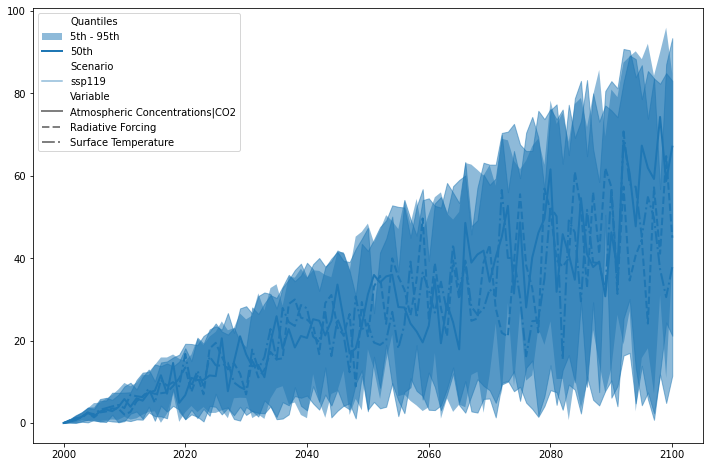

In [13]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(quantile_over="run_id")

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f0312df20a0>])

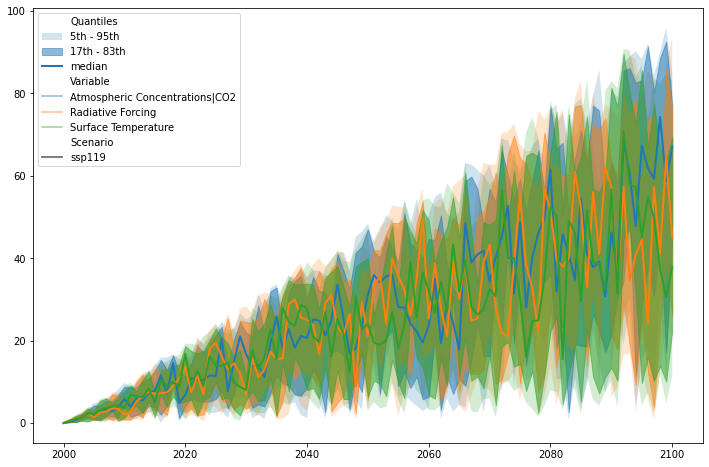

In [14]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(
    quantile_over="run_id",
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
)

#### Pre-calculated quantiles

Alternately, we can cast the output of `quantiles_over` to an `ScmRun` object for ease of filtering and plotting.

In [15]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun = ScmRun(summary_stats)
summary_stats_scmrun

<ScmRun (timeseries: 21, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario   unit                        variable
	0   example     0.05  World   ssp119      K             Surface Temperature
	1   example     0.05  World   ssp119  W/m^2               Radiative Forcing
	2   example     0.05  World   ssp119    ppm  Atmospheric Concentrations|CO2
	3   example     0.17  World   ssp119      K             Surface Temperature
	4   example     0.17  World   ssp119  W/m^2               Radiative Forcing
	5   example     0.17  World   ssp119    ppm  Atmospheric Concentrations|CO2
	6   example      0.5  World   ssp119      K             Surface Temperature
	7   example      0.5  World   ssp119  W/m^2               Radiative Forcing
	8   example      0.5  World   ssp119    ppm  Atmospheric Concentrations|CO2
	9   example     0.83  World   ssp119      K             Surface Temperature
	10  example     0.83  World   ssp119  W/m^2

As discussed above, casting the output of `quantiles_over` to an `ScmRun` object helps avoid repeatedly calculating the quantiles.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f0312d2feb0>])

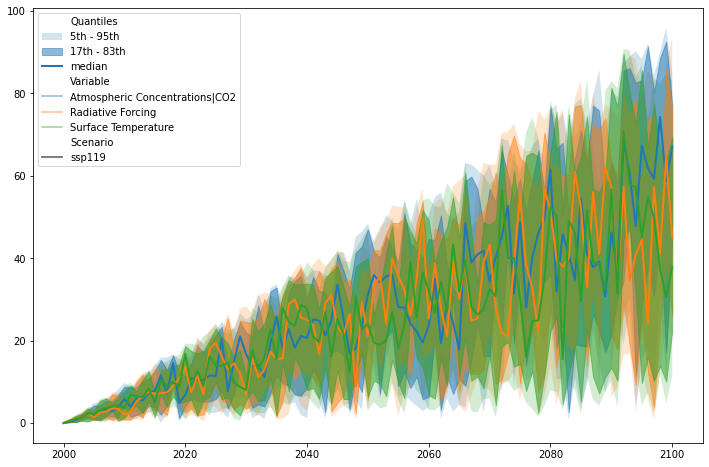

In [16]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.plumeplot(
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
    pre_calculated=True,
)

If we don't want a plume plot, we can always our standard lineplot method.

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

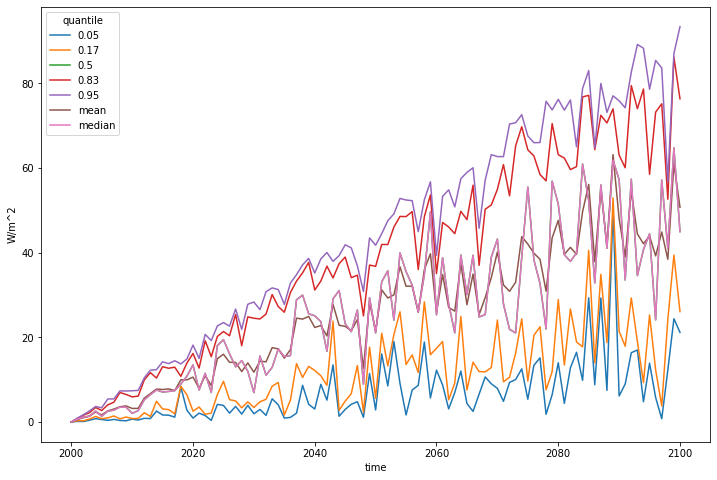

In [17]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.filter(variable="Radiative Forcing").lineplot(
    hue="quantile"
)

## `groupby`

The `groupby` method allows us to group the data by columns in `scmrun.meta` and then perform operations. An example is given below.

In [18]:
# NBVAL_IGNORE_OUTPUT
variable_means = []
for vdf in runs.groupby("variable"):
    vdf_mean = vdf.timeseries().mean(axis=0)
    vdf_mean.name = vdf.get_unique_meta("variable", True)
    variable_means.append(vdf_mean)

pd.DataFrame(variable_means)

time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,...,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
Atmospheric Concentrations|CO2,0.0,0.372314,0.818866,1.492401,2.243306,2.292707,2.718678,...,46.278662,60.848846,61.162341,54.373889,67.448361,53.789182,63.126450
Radiative Forcing,0.0,0.613253,1.022358,1.425384,2.370510,1.675960,2.645303,...,42.114376,43.934690,39.238384,44.880488,38.439152,61.006717,50.724298
Surface Temperature,0.0,0.507440,1.009117,1.352261,2.140397,2.114652,3.007618,...,53.877790,45.203341,44.174207,47.311248,40.127144,35.624771,42.326395


## `groupby_all_except`

The `groupby_all_except` method allows us to group the data by all columns in `scmrun.meta` except for a certain set. Like with `groupby`, we can then use the groups to perform operations. An example is given below. Note that, in most cases, using `process_over` is likely to be more useful. 

In [19]:
# NBVAL_IGNORE_OUTPUT
ensemble_means = []
for edf in runs.groupby_all_except("run_id"):
    edf_mean = edf.timeseries().mean(axis=0)
    edf_mean.name = edf.get_unique_meta("variable", True)
    ensemble_means.append(edf_mean)

pd.DataFrame(ensemble_means)

time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,...,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
Surface Temperature,0.0,0.507440,1.009117,1.352261,2.140397,2.114652,3.007618,...,53.877790,45.203341,44.174207,47.311248,40.127144,35.624771,42.326395
Radiative Forcing,0.0,0.613253,1.022358,1.425384,2.370510,1.675960,2.645303,...,42.114376,43.934690,39.238384,44.880488,38.439152,61.006717,50.724298
Atmospheric Concentrations|CO2,0.0,0.372314,0.818866,1.492401,2.243306,2.292707,2.718678,...,46.278662,60.848846,61.162341,54.373889,67.448361,53.789182,63.126450


As we said, in most cases using `process_over` is likely to be more useful. For example the above can be done using `process_over` in one line (and more metadata is retained).

In [20]:
# NBVAL_IGNORE_OUTPUT
runs.process_over("run_id", "mean")

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.507440    1.009117    1.352261    2.140397    2.114652    3.007618  ...   53.877790   45.203341   44.174207   47.311248   40.127144   35.624771   42.326395
                        W/m^2 Radiative Forcing                      0.0    0.613253    1.022358    1.425384    2.370510    1.675960    2.645303  ...   42.114376   43.934690   39.238384   44.880488   38.439152   61.006717   50.724298
                        ppm   Atmospheric Concentrations|CO2         0.0    0.372314    0.818866    1.492401    2.243306    2.292707    2.718678  ...   46.278662   60.848846   61.162341   54.373889   67.448361   53.789182   63.126450

[3 rows x 101 columns]